# DeepESN <br/>
https://github.com/gallicch/DeepRC-TF

In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, plot_confusion_matrix, classification_report

from DeepRC import *

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [3]:
df = pd.read_csv("data/train.csv")
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
num_classes = len(categories)
train, valid = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [4]:
df_test = pd.read_csv('data/test.csv')
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
cols = df_test.columns
label_cols = list(cols[2:])

test_labels_df = pd.read_csv('data/test_labels.csv')
df_test = df_test.merge(test_labels_df, on='id', how='left')
test_label_cols = list(df_test.columns[2:])
print('Null values: ', df_test.isnull().values.any()) #should not be any null sentences or labels
print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
print(f"Number of rows original: {df_test.shape[0]}")

df_test = df_test[~df_test[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
df_test['one_hot_labels'] = list(df_test[test_label_cols].values)
print(f"Number of rows after: {df_test.shape[0]}")
df_test.head()

Null values:  False
Same columns between train and test:  False
Number of rows original: 153164
Number of rows after: 63978


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [81]:
X_train = train.comment_text
y_train = train[categories]
X_valid = valid.comment_text
y_valid = valid[categories]
X_test = df_test.comment_text.values
y_test = df_test[categories].values

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train, mode='tfidf')
X_valid = tokenizer.texts_to_matrix(X_valid, mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test, mode='tfidf')

X_train = tf.expand_dims(X_train, axis=2)
X_valid = tf.expand_dims(X_valid, axis=2)

y_train = y_train.values
y_valid = y_valid.values

print('training set',X_train.shape,y_train.shape)
print('validation set',X_valid.shape,y_valid.shape)
print('test set',X_test.shape,y_test.shape)

training set (106912, 500, 1) (106912, 6)
validation set (52659, 500, 1) (52659, 6)
test set (63978, 500) (63978, 6)


In [ ]:
reservoir_units = 100
batch_size = 32
lr = 0.001

inputs = Input(shape=(X_train.shape[1],1), name='inputs')
reservoir = SimpleDeepReservoirLayer(units=reservoir_units, layers=5, trainable=False, name='reservoir')(inputs)
readout = Dense(num_classes, activation='sigmoid', name='readout')(reservoir)
model = Model(inputs, readout, name='DeepESN')

model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
%%timeit

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=4, verbose=1, validation_data=(X_valid,y_valid))

In [7]:
#model.save('esn-model')
W = model.layers[-1].get_weights()
np.save('readout', W)

/home/anto/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
print(f"Training accuracy: {history.history['accuracy'][-1]}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]}")

Training accuracy: 0.9929474592208862
Validation accuracy: 0.9927457571029663


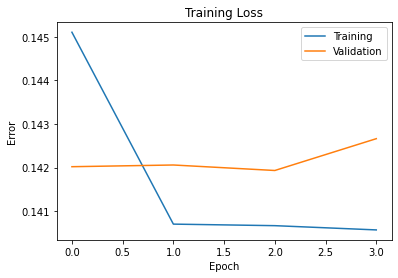

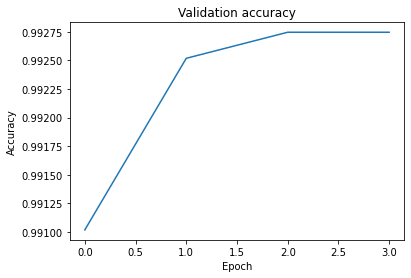

In [9]:
plt.title('Training Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training','Validation'])
plt.show()

plt.title('Validation accuracy')
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [10]:
scores = model.evaluate(X_test, y_test)

2000/2000 [==============================] - 464s 232ms/step - loss: 0.1445 - accuracy: 0.9967


In [11]:
print(f"Test accuracy: {scores[1]}")

Test accuracy: 0.9966707229614258


In [77]:
y_pred_test = model.predict(X_test)

'\nprint(f\'Test accuracy: {accuracy_score(y_test, y_pred_test)}\')\nmultilabel_confusion_matrix(y_test, y_pred_test)\n\nfor idx, category in enumerate(categories):\n    print(f"Scores \'{category}\':\n", classification_report(y_test[:,idx].numpy(), np.argmax(y_pred_test, axis=1)))'

In [97]:
y = np.where(y_pred_test > 0.5, 1, 0)

for idx, category in enumerate(categories):
    print(f"Scores '{category}':\n", classification_report(y_test[:,idx], y[:,idx]))

/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/

Scores 'toxic':
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     57888
           1       0.00      0.00      0.00      6090

    accuracy                           0.90     63978
   macro avg       0.45      0.50      0.48     63978
weighted avg       0.82      0.90      0.86     63978

Scores 'severe_toxic':
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     63611
           1       0.00      0.00      0.00       367

    accuracy                           0.99     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      0.99      0.99     63978



/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/

Scores 'obscene':
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     60287
           1       0.00      0.00      0.00      3691

    accuracy                           0.94     63978
   macro avg       0.47      0.50      0.49     63978
weighted avg       0.89      0.94      0.91     63978

Scores 'threat':
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.00      0.00      0.00       211

    accuracy                           1.00     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      1.00      1.00     63978



/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/

Scores 'insult':
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     60551
           1       0.00      0.00      0.00      3427

    accuracy                           0.95     63978
   macro avg       0.47      0.50      0.49     63978
weighted avg       0.90      0.95      0.92     63978

Scores 'identity_hate':
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     63266
           1       0.00      0.00      0.00       712

    accuracy                           0.99     63978
   macro avg       0.49      0.50      0.50     63978
weighted avg       0.98      0.99      0.98     63978



/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anto/.local/lib/python3.8/site-packages/